# create master json files from the raw data

In [1]:
import json
import numpy as np
import os
import sys
import time
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
import src.data_pipeline as dp
from src.config import Config

## steps

1. create the config file
2. filter the raw dataset and create a filtered dataset json in the interim folder
3. split and create the train, val, and test jsons from interim folder
4. parse target ds json
5. create train dataset

In [2]:
my_config = Config()
my_config.BATCH_SIZE = 2
raw_json_path = "C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/complete_toothwise_annotations.json"
intrim_dir = "C:/Users/anedaeij23/Project/tooth_classification_project/data/intrim"
img_dir = "C:/Users/anedaeij23/Project/tooth_classification_project/data/raw"

In [ ]:
dp.preprocess_raw_dataset(raw_json_path, intrim_dir, my_config , verbose= True)

Filtering out dark images...


removing dark images: 100%|██████████| 865/865 [00:38<00:00, 22.40oral cavity image/s]


Number of filtered annotations: 865
Converting annotations...
Number of annotations: 10017
Saving filtered annotations...
Done pre-processing the dataset.


In [4]:
master_json_path = os.path.join(intrim_dir, "filtered_Pla_annotations.json")

dp.split_dataset_json(master_json_path, intrim_dir, my_config)

True

In [3]:
ds_json_path = os.path.join(intrim_dir, "Pla_filtered_train.json")
train_records = dp.parse_dataset_json(ds_json_path, my_config, is_train_ds=True)

In [4]:
train_ds = dp.build_tf_dataset(train_records, my_config)

In [ ]:
# Assume ds is your built tf.data.Dataset
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Images dtype:", images.dtype)
    print("Labels batch shape:", labels.shape)
    print("Labels dtype:", labels.dtype)


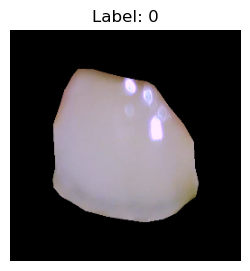

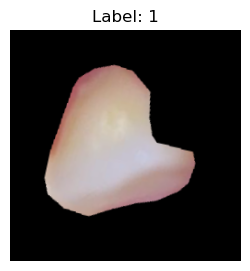

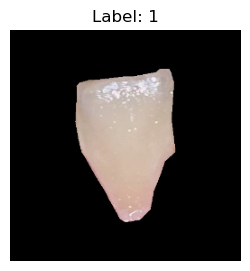

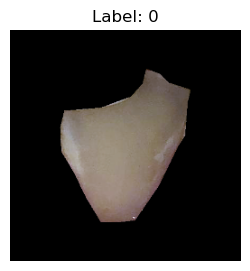

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate over one batch from your dataset
for images, labels in train_ds.take(2):
    images_np = images.numpy()   # Convert the tensor to a NumPy array.
    labels_np = labels.numpy()   # Likewise for labels.
    
    # Display each image in the batch.
    for i in range(images_np.shape[0]):
        # Depending on how your images are preprocessed, you may need to clip or cast them.
        # For example, if they are float values in the range [0, 255], you can cast to uint8:
        image_to_show = np.clip(images_np[i], 0, 255).astype(np.uint8)
        
        plt.figure(figsize=(3, 3))
        plt.imshow(image_to_show)
        plt.title(f"Label: {labels_np[i]}")
        plt.axis('off')
        plt.show()


## tests

In [2]:
# Example usage:
path = 'C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/MOVIPKA-front_right-right-120_PumM5JqRU3.jpg'
dark_result = dp.is_darker_than_threshold(path, 0.25)
print(dark_result)

False


In [81]:
tooth_diag_annots = json.load(open(os.path.join("C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/", "complete_toothwise_annotations.json")))

In [ ]:
new_json = dp.remove_dark_images_from_json(tooth_diag_annots, "C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/" )

In [97]:
plaque_annotations = dp.convert_annotations(tooth_diag_annots, target_class='Pla')

In [99]:
# Save the new annotations to a file
with open("C:/Users/anedaeij23/Project/tooth_classification_project/data/intrim/plaque_annotations.json", "w") as f:
    json.dump(plaque_annotations, f)

In [2]:
img_path = 'C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/HAJEVSU-front_left-left-315_nq0WmtTmrN.jpg'

In [ ]:
from skimage import io
import tensorflow as tf
import matplotlib.pyplot as plt
image = io.imread(img_path)
# image = tf.io.read_file(img_path)
# image = tf.image.decode_jpeg(image, channels=3)
img = dp.pad_and_resize(image)
plt.imshow(img)
plt.show()

In [2]:
annot_path = 'C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/complete_toothwise_annotations.json'
data_dir = 'C:/Users/anedaeij23/Project/tooth_classification_project/'
dp.preprocess_dataset(
    json_annotations_path= annot_path,
    output_dir= os.path.join(data_dir,Config.OUTPUT_DIR),
    image_dir= os.path.join(data_dir,Config.IMAGE_DIR),
    target_dim= Config.TARGET_DIM,
    mask_bg= Config.MASK_BG,
    verbose= True
)

Filtering out dark images...
JUKUJKA-front_left-left-363_79Ils3voSf.jpg was dark, removed
HIKOJSI-front_right-right-105_eaY2aW5hSH.jpg was dark, removed
TUREVTA-front_left-left-311_FlNiW2pc9R.jpg was dark, removed
TUREVTA-front_left-left-311_aPuvqDg1Fa.jpg was dark, removed
KINOPTA-front_right-right-297_QvKzBksRPQ.jpg was dark, removed
HUNIHTU-front_left-left-478_NI7y31wkUU.jpg was dark, removed
HUNIHTU-front_left-left-478_YjaKKtiF7W.jpg was dark, removed
PETIHPO-front_left-left-253_tf6WFxiCa1.jpg was dark, removed
PETIHPO-front_left-left-253_xw8zLfdv6Q.jpg was dark, removed
HAJATRO-front-392_P9pRrEUCqs.jpg was dark, removed
HAJATRO-front-392_lTj0bz6PtH.jpg was dark, removed
HAJATRO-front-392_SKoRG6M0Mc.jpg was dark, removed
HAJATRO-front-392_cgHPkHdoyI.jpg was dark, removed
HAJATRO-front-392_ncb6GWaFqV.jpg was dark, removed
HAJATRO-front-392_UgoxN-H4hh.jpg was dark, removed
KIJOLLA-upper-116_871HM4EYSa.jpg was dark, removed
KIJOLLA-upper-116_1OhrWOmK3N.jpg was dark, removed
KIJOLLA-up

Processing images:  40%|███▉      | 4004/10017 [05:31<06:06, 16.39image/s]  c:\Users\anedaeij23\Project\tooth_classification_project\src\data_pipeline.py:595: UserWarning: C:/Users/anedaeij23/Project/tooth_classification_project/data/processed\RAHIHSO-lower-48_6O7OY60DkG.jpg is a low contrast image
  io.imsave(out_path, image)
Processing images:  89%|████████▊ | 8873/10017 [11:46<01:03, 18.06image/s]c:\Users\anedaeij23\Project\tooth_classification_project\src\data_pipeline.py:595: UserWarning: C:/Users/anedaeij23/Project/tooth_classification_project/data/processed\VEHEVKA-upper-291_jNRsr7s09J.jpg is a low contrast image
  io.imsave(out_path, image)
Processing images: 100%|██████████| 10017/10017 [13:43<00:00, 12.17image/s]

Done pre-processing the dataset.


In [2]:
import json
annot_path = 'C:/Users/anedaeij23/Project/tooth_classification_project/data/processed/filtered_Pla_annotations.json'
data_dir = 'C:/Users/anedaeij23/Project/tooth_classification_project/'


#loading the raw json file
with open(annot_path, 'r', encoding='utf-8') as f:
    annotations = json.load(f) 
dataset = dp.build_tf_dataset(annotations)

In [25]:
data = dataset.prefetch(1)
for batch in data:
    print(batch[0].shape, batch[1].shape)
    break

(32, 256, 256, 3) (32,)


In [ ]:
import json
annot_path = 'C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/complete_toothwise_annotations.json'
data_dir = 'C:/Users/anedaeij23/Project/tooth_classification_project/'


#loading the raw json file
with open(annot_path, 'r', encoding='utf-8') as f:
    annotations = json.load(f) 
converted_annotations = dp.convert_annotations(annotations, target_class='Pla')

with open(os.path.join(os.path.join(data_dir,Config.OUTPUT_DIR),f"filtered_{Config.TARGET_CLASS}_annotations.json"), "w", encoding="utf-8") as f:
    json.dump(converted_annotations, f)

In [3]:
dp.remove_dark_images_from_json(converted_annotations, os.path.join(data_dir,Config.IMAGE_DIR))
# with open(os.path.join(os.path.join(data_dir,Config.OUTPUT_DIR),f"filtered2_{Config.TARGET_CLASS}_annotations.json"), "w", encoding="utf-8") as f:
#     json.dump(filtered_annotations, f)

KeyError: 'teeth_data'

In [3]:
dp.is_darker_than_threshold('C:/Users/anedaeij23/Project/tooth_classification_project/data/raw/HAJATRO-upper-392_EsJvScrhpS.jpg')

False

In [3]:
test_conf = Config()
test_conf.TEST_RATIO

0.1

In [4]:
Config.TEST_RATIO

0.1